# Определение возраста покупателей сетевого супермаркета

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Загрузим  данные и посмотрим на размер выборки
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


No handles with labels found to put in legend.


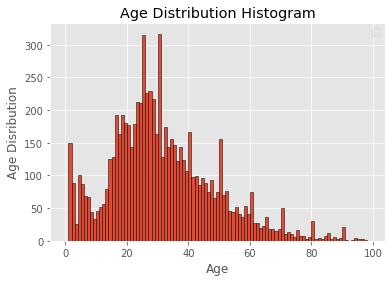

In [2]:
# Построим график распределения возраста в выборке
plt.style.use('ggplot')
ages = labels['real_age'].to_numpy()
bins = np.arange(100)  
plt.hist(ages, bins=bins, edgecolor='black')
plt.xlabel("Age")
plt.ylabel("Age Disribution")
plt.title("Age Distribution Histogram")
plt.legend()
plt.show()

(32, 224, 224, 3)


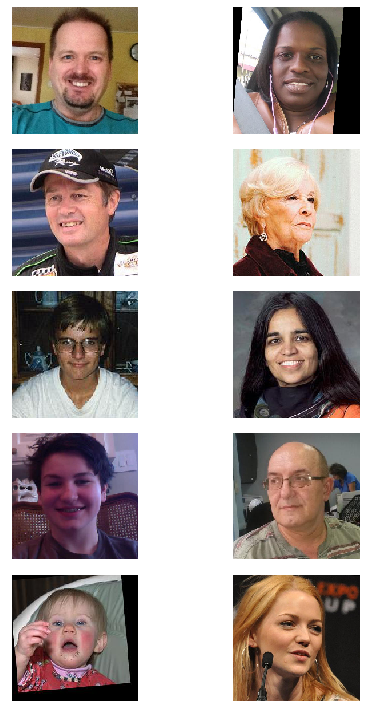

In [3]:
#Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет
features, target = next(train_gen_flow)
print(features.shape)
# выводим 10 изображений
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(5, 2, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Результат исследовательского анализа данных:
1. 7591 файлов изображений, на мой взгляд, достаточный размер выборки для эффективной работы с датасетом.

2. По гистограмме видны пики каждые 10 лет начиная с 20 лет. Возможно, это связано с тем, что возрастные изменения до примерно 20 лет довольно заметны и еще можно различить 12-летнего от 15-летнего, но чем старше становится человек, тем сложнее определить возраст, поэтому разметчики, видимо, склонны округлять до 10 лет.

3. Фото имеют разную цветность. Они отличаются по качеству, видны фото с разными уголами поворота и разным масштабом. Для устранения этих различий можно применить аугментацию. Например, отражение: horizontal_flip, повороты: rotation_range, сдвиги по ширине и высоте: width_shift_range и height_shift_range.

## Обучение модели

Код в этом разделе оформлен не как ячейка с кодом, а как код в текстовой ячейке, так как данный код запускался в отдельном GPU-тренажёре.

### Код обучения модели

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

# Загрузка обучающей выборки
def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'),
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

# Загрузка валидационной выборки 
def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'),
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


# Создание модели
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(90, activation='relu'))
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mae'])
    return model

# Запуск модели
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

### Вывод результата обучения модели

```
Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 101s - loss: 228.1480 - mae: 10.8633 - val_loss: 835.2694 - val_mae: 24.0047
Epoch 2/15
178/178 - 44s - loss: 55.3281 - mae: 5.6416 - val_loss: 734.1669 - val_mae: 22.0509
Epoch 3/15
178/178 - 43s - loss: 27.8572 - mae: 4.0123 - val_loss: 291.9848 - val_mae: 12.5419
Epoch 4/15
178/178 - 43s - loss: 18.6494 - mae: 3.2921 - val_loss: 135.3532 - val_mae: 9.1400
Epoch 5/15
178/178 - 43s - loss: 13.3399 - mae: 2.7724 - val_loss: 85.0245 - val_mae: 7.1403
Epoch 6/15
178/178 - 43s - loss: 10.8494 - mae: 2.4666 - val_loss: 72.3696 - val_mae: 6.3251
Epoch 7/15
178/178 - 43s - loss: 9.8029 - mae: 2.3198 - val_loss: 65.9202 - val_mae: 6.1038
Epoch 8/15
178/178 - 43s - loss: 8.8199 - mae: 2.1664 - val_loss: 87.0006 - val_mae: 6.8179
Epoch 9/15
178/178 - 43s - loss: 7.9009 - mae: 2.0825 - val_loss: 67.6066 - val_mae: 6.2008
Epoch 10/15
178/178 - 43s - loss: 7.1396 - mae: 2.0173 - val_loss: 77.4602 - val_mae: 6.4919
Epoch 11/15
178/178 - 43s - loss: 6.3283 - mae: 1.8838 - val_loss: 75.8180 - val_mae: 6.7853
Epoch 12/15
178/178 - 43s - loss: 5.5820 - mae: 1.7560 - val_loss: 73.1966 - val_mae: 6.3017
Epoch 13/15
178/178 - 43s - loss: 5.3399 - mae: 1.7243 - val_loss: 66.8957 - val_mae: 6.2012
Epoch 14/15
178/178 - 44s - loss: 5.1272 - mae: 1.6958 - val_loss: 64.1784 - val_mae: 6.0606
Epoch 15/15
178/178 - 44s - loss: 5.0263 - mae: 1.6788 - val_loss: 69.8048 - val_mae: 6.2982

```

## Анализ обученной модели

* Найдено 7591 файлов изображений.
* В максимальном объеме представлены фото людей в возрасте от 23 до 30 лет. Среди них преобладают фото конкретно 25-летних и 30-летних людей.
* В минимальном объеме представлены фотографии людей в возрасте от 95 до 100 лет.
* Используя архитектуру ResNet50 построили и обучили свёрточную нейронную сеть на датасете с фотографиями людей.
* Итоговое значения MAE на тестовой выборке 6.29